<a href="https://colab.research.google.com/github/LisaRXN/bigdata_python/blob/main/data_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data import and preparation


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from collections import Counter
import networkx as nx
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px
import networkx as nx


# Loading files
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')
order_products = pd.read_csv('order_products.csv')

datasets = {
    "orders": orders,
    "products": products,
    "aisles": aisles,
    "departments": departments,
    "order_products": order_products
}

# Checking for null values and duplicates
for name, data in datasets.items():
    print(f"\n{name.capitalize()} dataset:")

    # undefined values
    nan_counts = data.isna().sum()
    print("Valeurs manquantes :")
    print(nan_counts)

    # null values
    null_counts = data.isnull().sum()
    print("Valeurs nulles :")
    print(null_counts[null_counts > 0])

    # duplicates
    duplicate_count = data.duplicated().sum()
    print(f"Lignes dupliquées : {duplicate_count}")
    print("-" * 40)



Orders dataset:
Valeurs manquantes :
order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64
Valeurs nulles :
days_since_prior_order    206209
dtype: int64
Lignes dupliquées : 0
----------------------------------------

Products dataset:
Valeurs manquantes :
product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64
Valeurs nulles :
Series([], dtype: int64)
Lignes dupliquées : 0
----------------------------------------

Aisles dataset:
Valeurs manquantes :
aisle_id    0
aisle       0
dtype: int64
Valeurs nulles :
Series([], dtype: int64)
Lignes dupliquées : 0
----------------------------------------

Departments dataset:
Valeurs manquantes :
department_id    0
department       0
dtype: int64
Valeurs nulles :
Series([], dtype: int64)
Lignes dupliquées : 0
----------------

# Data Analyse

This project aims to analyze user purchasing behaviors to:
- Optimize stock management and reduce waste by identifying consumption trends.
- Improve store organization by studying purchase associations, simplifying the customer experience.
- 	Promote sustainable consumption by encouraging reduced use of packaging, through targeted analyses of purchasing preferences.

# 1. Optimized stock management to reduce waste


**Problem Statement:**

How can we predict the products that will be popular in the future to better manage inventory, avoid stockouts, and reduce waste?

The data analysis will focus on three main areas:
- Identifying the most ordered products by department.
- Analyzing order frequency to anticipate demand peaks.
- Forecasting future demand using simple

**Some sales statistics**

---



Total number of product purchases and reorders

In [ ]:
# Total number of products
total_products = products['product_id'].count()
print("Total number of products : ", total_products)

# Total number of orders
total_ordered = order_products['order_id'].count()
print("Total number of ordered products : ", total_ordered)

# Total number of reorders
total_reordered = order_products[order_products['reordered'] == 1].groupby('order_id')['product_id'].nunique().count()
print("Total number of reordered products : ", total_reordered)

Total number of products :  49688
Total number of ordered products :  23713455
Total number of reordered products :  2065958


Total number of regular and unique visitor

In [ ]:
# Total number of regular visitors
user_id_count = orders['user_id'].value_counts()
regular_visitors = (user_id_count > 10).sum()
print("Number of regular visitors:", regular_visitors)

# Total number of unique visitors
unique_visitors = orders['user_id'].nunique()
print("Number of unique visitor : ", unique_visitors)

Number of regular visitors: 101696
Number of unique visitor :  206209


**Identifying the most ordered and reordered reoproducts**

---



1. What are the 25 most purchased products?

In [ ]:
# Total number of times a product has been purchased
product_counts = order_products.groupby('product_id').size().reset_index(name='order_count')

# Merge with the “products” table to obtain product names
product_counts_merged = product_counts.merge(products, on='product_id')

# Sort by number of order count
top_products = product_counts_merged.sort_values(by='order_count', ascending=False).head(25)

# Percentage purchase for each product
order_pourcent = top_products['order_count'] * 100 / total_ordered
top_products['pourcent'] = order_pourcent.round(1)

# Display
print("Top of 25 most purchased products", "\n")
display(top_products[['product_name', 'order_count', 'pourcent']])

# Export CSV
top_products[['product_name', 'order_count', 'pourcent']].to_csv('top_products.csv', index=False, encoding='utf-8')

Top of 25 most purchased products 



,product_name,order_count,pourcent
24805,Banana,345948,1.5
13149,Bag of Organic Bananas,277460,1.2
21098,Organic Strawberries,193664,0.8
21863,Organic Baby Spinach,176568,0.7
47106,Organic Hass Avocado,156096,0.7
47663,Organic Avocado,129300,0.5
47523,Large Lemon,111663,0.5
16764,Strawberries,104339,0.4
26161,Limes,102789,0.4
27795,Organic Whole Milk,101039,0.4


2. What are the 25 most reordered products?

In [ ]:
# Filter reordered products (reordered = 1)
reordered_counts = order_products[order_products['reordered'] == 1].groupby('product_id').size().reset_index(name='reordered_count')

# Merge with “products” dataset to obtain product names
reordered_counts_merged = reordered_counts.merge(products, on='product_id')

# Sort by number of reordered count
top_reordered_products = reordered_counts_merged.sort_values(by='reordered_count', ascending=False).head(25)

# reordered percentages for each product
reorder_pourcent = top_reordered_products['reordered_count'] * 100 / total_reordered
top_reordered_products['pourcent'] = reorder_pourcent.round(1)

# Display
print("Top of 25 most reordered products", "\n")
display(top_reordered_products[['product_name', 'reordered_count', 'pourcent']])

# Export CSV
top_reordered_products[['product_name', 'reordered_count', 'pourcent']].to_csv('top_reordered_products.csv', index=False, encoding='utf-8')


Top of 25 most reordered products 



,product_name,reordered_count,pourcent
16553,Banana,34802,14.2
8706,Bag of Organic Bananas,27174,11.1
14061,Organic Strawberries,17843,7.3
14581,Organic Baby Spinach,16172,6.6
31495,Organic Hass Avocado,14552,5.9
31880,Organic Avocado,11527,4.7
18529,Organic Whole Milk,9933,4.0
31783,Large Lemon,9314,3.8
18606,Organic Raspberries,8926,3.6
11171,Strawberries,8700,3.5


 Visualition of the 10 most reordered products


In [ ]:
# Visualition of the 10 most reordered products
fig = px.bar(top_reordered_products,
             x='reordered_count',
             y='product_name',
             color='reordered_count',
             orientation='h',  # Pour des barres horizontales
             title="Top 10 of reordered products",
             labels={'reordered_count': 'Number of orders', 'product_name': 'Product'},
             color_continuous_scale='viridis',
             text='reordered_count')  # Afficher le nombre d'achats sur les barres

# Customize chart
fig.update_traces(texttemplate='%{text}', textposition='outside', showlegend=False)  # Afficher les valeurs sur les barres
fig.update_layout(
    title="Top 10 of reordered products",
    xaxis_title="Number of orders",
    yaxis_title="Product",
    font=dict(family="Arial, sans-serif", size=12)
)

fig.show()

3.  What are the departments and aisles generating the most orders per year?

In [ ]:
# Departments

# Merge products to departments
product_departments = products.merge(departments, on='department_id')

# number of products sold by department
department_orders = order_products.merge(product_departments, on='product_id').groupby('department').size().reset_index(name='order_count')

# Sort by number of order count
top_departments = department_orders.sort_values(by='order_count', ascending=False).head(6)

# Sales percentages for each department
department_pourcent = department_orders['order_count'] * 100 / top_departments['order_count'].sum()
top_departments['pourcent'] = department_pourcent.round(1)


# Aisles

# Merge products to aisles
product_aisles = products.merge(aisles, on='aisle_id')

# number of products sold by aisle
aisle_orders = order_products.merge(product_aisles, on='product_id').groupby('aisle').size().reset_index(name='order_count')

# Sort by number of order count
top_aisles = aisle_orders.sort_values(by='order_count', ascending=False).head(6)

# Sales percentages for each aisles
aisle_pourcent = aisle_orders['order_count'] * 100 / top_aisles['order_count'].sum()
top_aisles['pourcent'] = aisle_pourcent.round(1)


display(top_departments[['department', 'order_count', 'pourcent']])
display(top_aisles[['aisle', 'order_count','pourcent']])

top_departments[['department', 'order_count', 'pourcent']].to_csv('top_departments.csv', index=False, encoding='utf-8')
top_aisles[['aisle', 'order_count','pourcent']].to_csv('top_aisles.csv', index=False, encoding='utf-8')

,department,order_count,pourcent
19,produce,6930490,38.6
7,dairy eggs,3959009,22.0
20,snacks,2111797,11.8
3,beverages,1966285,10.9
10,frozen,1633735,9.1
16,pantry,1370757,7.6


,aisle,order_count,pourcent
50,fresh fruits,2663963,30.0
53,fresh vegetables,2497929,28.1
98,packaged vegetables fruits,1290642,14.5
133,yogurt,1061177,11.9
93,packaged cheese,716809,8.1
83,milk,651947,7.3


 Visualition of the top 5 aisles and departments

In [ ]:
# top 5 dpartments
top_departments = department_orders.sort_values(by='order_count', ascending=False).head(6)
top_departments.iloc[5, top_departments.columns.get_loc('department')] = 'others'

# top 5 aisles
top_aisles = aisle_orders.sort_values(by='order_count', ascending=False).head(6)
top_aisles.iloc[5, top_aisles.columns.get_loc('aisle')] = 'others'

# pastel_colors = ['#fcd3d2', '#5a55cd', '#01c3cb', "ff7073", '#eae9fb']
pastel_colors = ['#87ccdb', '#b5b6bd', '#d49ea0', '#ea8383', '#8bae70', '#c1bd67', '#f3cb5c']

# Sector diagram for departments
fig_departments = go.Figure(go.Pie(
    labels=top_departments['department'],
    values=top_departments['order_count'],
    hoverinfo='label+percent',
    textinfo='label+percent',
    marker=dict(colors=pastel_colors)
    # marker=dict(colors=px.colors.qualitative.Pastel[:len(top_departments)]),
))

# Sector diagram for aisles
fig_aisles = go.Figure(go.Pie(
    labels=top_aisles['aisle'],
    values=top_aisles['order_count'],
    hoverinfo='label+percent',
    textinfo='label+percent',
    marker=dict(colors=pastel_colors)
    # marker=dict(colors=px.colors.qualitative.Pastel[:len(top_aisles)]),
))


fig_departments.update_layout(
    title="Top 5 departments",
    showlegend=True,
)
fig_aisles.update_layout(
    title="Top 5 aisles",
    showlegend=True,
)
fig_departments.show()
fig_aisles.show()

**Analyzing order frequency to anticipate demand peaks**

---



4. What is the total number of visitors and the number of visitors per week?








In [ ]:
# Number of total visitors per week
visitors_week = orders.groupby('order_dow').size().reset_index(name='visitors_count')
print("Number of total visitors per day :")
print(visitors_week)
print(visitors_week['visitors_count'].sum())

# Number of unique visitors per week
unique_visitors_week = orders.groupby('order_dow')['user_id'].nunique().reset_index(name='unique_visitors_count')
print("Number of unique visitor per day :")
print(unique_visitors_week)
print(unique_visitors_week['unique_visitors_count'].sum())


# Merge regular + unique visitors
merge_visitors_week = visitors_week.merge(unique_visitors_week, on='order_dow')


# Change numbers into day names
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
merge_visitors_week['day_name'] = merge_visitors_week['order_dow'].apply(lambda x: days[int(x)])

# Export en csv
merge_visitors_week.to_csv('visitors_week.csv', index=False, encoding='utf-8')


melted_data = merge_visitors_week.melt(id_vars='day_name',
                                       value_vars=['visitors_count', 'unique_visitors_count'],
                                       var_name='Type',
                                       value_name='Count')

fig = px.line(melted_data,
              x='day_name',
              y='Count',
              color='Type',
              title="Total vs Unique Visitors per Day",
              markers=True,  # Ajoute des marqueurs sur chaque point de données
              labels={'day_name': 'Day of the Week', 'Count': 'Visitor Count'},  # Personnalisation des labels
              template='plotly',  # Style de graphique
              line_shape='linear')  # Utilisation de lignes droites

# Personnalisation du graphique
fig.update_layout(
    title="Total vs Unique Visitors per Day",
    xaxis_title="Day of the Week",
    yaxis_title="Visitor Count",
    legend_title="Visitor Type",
    font=dict(family="Arial, sans-serif", size=12)
)

# Affiche le graphique
fig.show()

Number of total visitors per day :
   order_dow  visitors_count
0          0          600905
1          1          587478
2          2          467260
3          3          436972
4          4          426339
5          5          453368
6          6          448761
3421083
Number of unique visitor per day :
   order_dow  unique_visitors_count
0          0                 152288
1          1                 158096
2          2                 146968
3          3                 142172
4          4                 139368
5          5                 140892
6          6                 135123
1014907


5. What are the days of the week and times of day generating the most orders?


In [ ]:
# Number of purchases per day of the week
daily_orders = orders.groupby('order_dow').size().reset_index(name='order_count')
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_orders['day_name'] = daily_orders['order_dow'].apply(lambda x: days[int(x)])

# Affichage
print("Day with maximum orders:", daily_orders.sort_values(by='order_count', ascending=False).iloc[0]['day_name'])
print("Day with minimum orders:", daily_orders.sort_values(by='order_count', ascending=True).iloc[0]['day_name'])
print('\n')

# Number of purchases per hour of the day
hourly_orders = orders.groupby('order_hour_of_day').size().reset_index(name='order_count')

# Affichage
display(daily_orders)
print('\n')
display(hourly_orders)

# Export en csv
daily_orders.to_csv('dayly_orders.csv', index=False, encoding='utf-8')
hourly_orders.to_csv('hourly_orders.csv', index=False, encoding='utf-8')

Day with maximum orders: Monday
Day with minimum orders: Friday




,order_dow,order_count,day_name
0,0,600905,Monday
1,1,587478,Tuesday
2,2,467260,Wednesday
3,3,436972,Thursday
4,4,426339,Friday
5,5,453368,Saturday
6,6,448761,Sunday


,order_hour_of_day,order_count
0,0,22758
1,1,12398
2,2,7539
3,3,5474
4,4,5527
5,5,9569
6,6,30529
7,7,91868
8,8,178201
9,9,257812




Day with maximum orders: Mon
Day with minimum orders: Fri
Hour of maximum orders:  13.0 





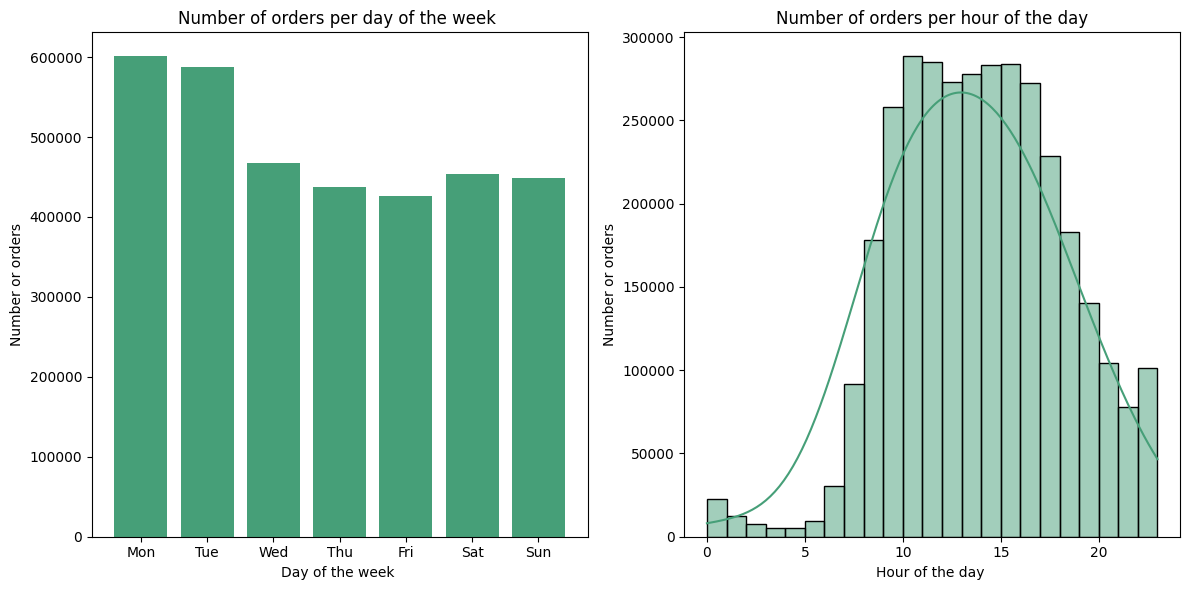

In [ ]:
# Number of purchases per day of the week
daily_orders = orders.groupby('order_dow').size().reset_index(name='order_count')
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
daily_orders['day_name'] = daily_orders['order_dow'].apply(lambda x: days[int(x)])

# Number of purchases per hour of the day
hourly_orders = orders.groupby('order_hour_of_day').size().reset_index(name='order_count')

# Figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# histogram for purchases per day of the week
axes[0].bar(daily_orders['day_name'], daily_orders['order_count'], color="#469f78")
axes[0].set_title("Number of orders per day of the week ")
axes[0].set_xlabel("Day of the week ")
axes[0].set_ylabel("Number or orders")

# histogram for purchases per hour of the day
ax = sns.histplot(data=hourly_orders, x='order_hour_of_day', weights='order_count', binwidth=1, kde=True, color="#469f78")
axes[1].set_title("Number of orders per hour of the day")
axes[1].set_xlabel("Hour of the day ")
axes[1].set_ylabel("Number or orders")

kde_line = ax.lines[0]
x_kde = kde_line.get_xdata()
y_kde = kde_line.get_ydata()
max_value = max(y_kde)
max_position = x_kde[np.argmax(y_kde)]

print('\n')
print("Day with maximum orders:", daily_orders.sort_values(by='order_count', ascending=False).iloc[0]['day_name'])
print("Day with minimum orders:", daily_orders.sort_values(by='order_count', ascending=True).iloc[0]['day_name'])
print( 'Hour of maximum orders: ', max_position.round(0), '\n')
print('\n')

plt.tight_layout()
plt.show()

6. Correlation between the day of the week and the departments of the most ordered products?

<ipython-input-9-c35c5575da18>:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  orders_departments_grouped = orders_departments.groupby(['day_name', 'department']).size().reset_index(name='order_count')


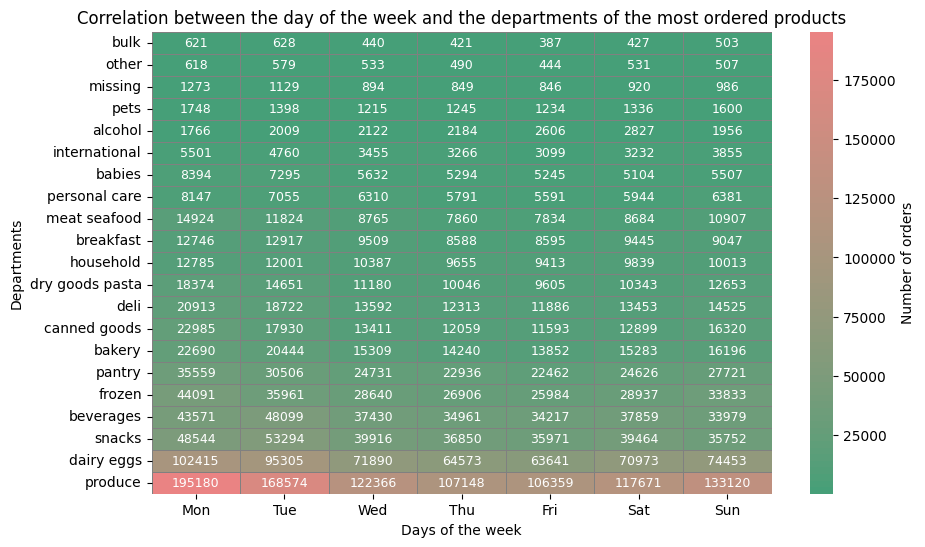

In [9]:
# Échantillonner
orders_sample = orders.sample(frac=0.1, random_state=42)
order_products_sample = order_products.sample(frac=0.1, random_state=42)

orders_departments = (
    orders_sample
    .merge(order_products, on='order_id', how='left')
    .merge(products, on='product_id', how='left')
    .merge(departments, on='department_id', how='left')
)

days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

orders_departments['day_name'] = orders_departments['order_dow'].apply(lambda x: days[int(x)])
orders_departments['day_name'] = pd.Categorical(orders_departments['day_name'], categories=days, ordered=True)


# Group data by day of week and department
orders_departments_grouped = orders_departments.groupby(['day_name', 'department']).size().reset_index(name='order_count')

# Sort departments by total sales, from largest to smallest
department_sales = orders_departments_grouped.groupby('department')['order_count'].sum().reset_index().sort_values(by='order_count', ascending=True)

# pivot for departments vs. days of the week
department_pivot = orders_departments_grouped.pivot(index='department', columns='day_name', values='order_count')
department_pivot = department_pivot.loc[department_sales['department']]


# Visualization with a heatmap
plt.figure(figsize=(10, 6))
# custom_cmap = sns.color_palette(
# ['#5a55cd', '#6055cb', '#6656c9', '#6c56c8', '#7157c6', '#7657c4', '#7a58c2', '#7f58c0', '#8358bf', '#8759bd', '#8c59bb', '#8f5ab9', '#935ab8', '#975bb6', '#9b5bb4', '#9e5cb2', '#a25cb0', '#a55daf', '#a95dad', '#ac5eab', '#af5ea9', '#b25fa7', '#b65fa6', '#b960a4', '#bc61a2', '#bf61a0', '#c2629e', '#c5629c', '#c7639b', '#ca6399', '#cd6497', '#d06595', '#d36593', '#d66691', '#d86690', '#db678e', '#de688c', '#e0688a', '#e36988', '#e66986', '#e86a84', '#eb6b83', '#ed6b81', '#f06c7f', '#f26d7d', '#f56d7b', '#f86e79', '#fa6f77', '#fd6f75', '#ff7073']
#  )
custom_cmap = sns.color_palette(
['#469f78', '#4a9f78', '#4e9f78', '#529e78', '#559e79', '#599e79', '#5c9e79', '#5f9e79', '#639e79', '#669d79', '#699d79', '#6c9d7a', '#6e9d7a', '#719c7a', '#749c7a', '#779c7a', '#799c7a', '#7c9b7b', '#7f9b7b', '#819b7b', '#849b7b', '#869a7b', '#889a7b', '#8b9a7b', '#8d997c', '#90997c', '#92997c', '#94987c', '#97987c', '#99987c', '#9b977d', '#9d977d', '#a0977d', '#a2967d', '#a4967d', '#a6967d', '#a8957e', '#aa957e', '#ad947e', '#af947e', '#b1947e', '#b3937e', '#b5937e', '#b7927f', '#b9927f', '#bb917f', '#bd917f', '#bf907f', '#c1907f', '#c38f80', '#c58f80', '#c78e80', '#c98e80', '#cb8d80', '#cd8d80', '#cf8c81', '#d18c81', '#d38b81', '#d58a81', '#d78a81', '#d98981', '#db8982', '#dd8882', '#df8782', '#e18782', '#e28682', '#e48582', '#e68483', '#e88483', '#ea8383']
)
sns.heatmap(
    department_pivot,
    cmap=custom_cmap,
    annot=True,
    fmt='.0f',
    annot_kws={'size': 9},
    cbar_kws={'label': 'Number of orders'},
    linewidths=0.5,
    linecolor='gray')

plt.title("Correlation between the day of the week and the departments of the most ordered products")
plt.xlabel("Days of the week")
plt.ylabel("Departments")
plt.show()

7. Correlation between hours of the day and departments of the most ordered products?

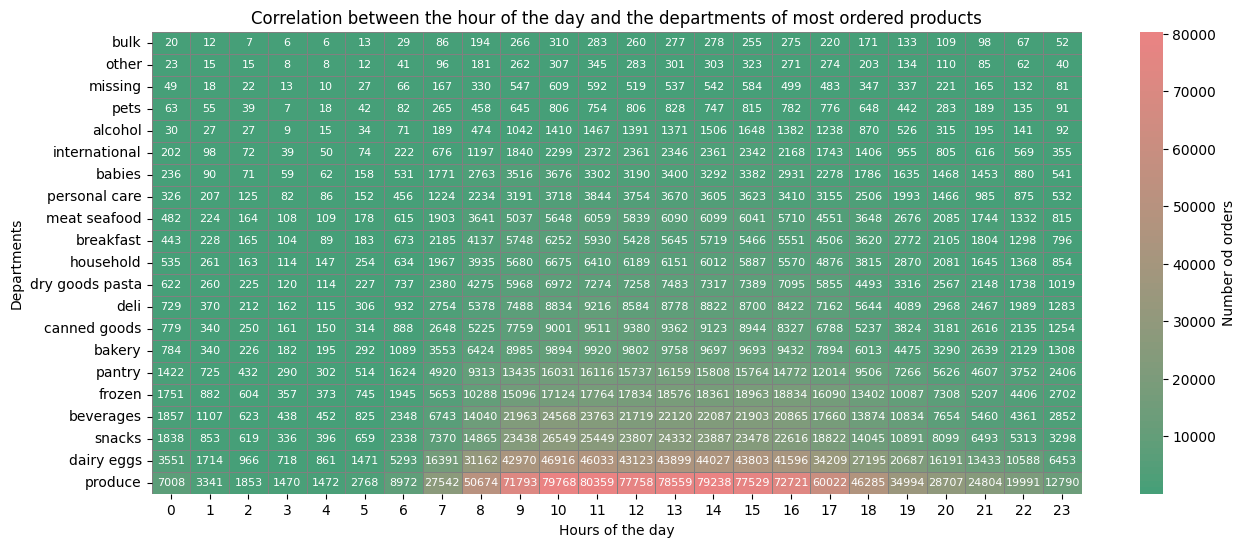

In [10]:
# Group data by time and department
orders_departments_grouped = orders_departments.groupby(['order_hour_of_day', 'department']).size().reset_index(name='order_count')

# Sort departments by total sales, from largest to smallest
department_sales = orders_departments_grouped.groupby('department')['order_count'].sum().reset_index().sort_values(by='order_count', ascending=True)

# pivot for departments vs. days of the week
department_pivot = orders_departments_grouped.pivot(index='department', columns='order_hour_of_day', values='order_count')

department_pivot = department_pivot.loc[department_sales['department']]

# Visualization with a heatmap
# custom_cmap = sns.color_palette(
# ['#5a55cd', '#6055cb', '#6656c9', '#6c56c8', '#7157c6', '#7657c4', '#7a58c2', '#7f58c0', '#8358bf', '#8759bd', '#8c59bb', '#8f5ab9', '#935ab8', '#975bb6', '#9b5bb4', '#9e5cb2', '#a25cb0', '#a55daf', '#a95dad', '#ac5eab', '#af5ea9', '#b25fa7', '#b65fa6', '#b960a4', '#bc61a2', '#bf61a0', '#c2629e', '#c5629c', '#c7639b', '#ca6399', '#cd6497', '#d06595', '#d36593', '#d66691', '#d86690', '#db678e', '#de688c', '#e0688a', '#e36988', '#e66986', '#e86a84', '#eb6b83', '#ed6b81', '#f06c7f', '#f26d7d', '#f56d7b', '#f86e79', '#fa6f77', '#fd6f75', '#ff7073']
#     )
custom_cmap = sns.color_palette(
['#469f78', '#4a9f78', '#4e9f78', '#529e78', '#559e79', '#599e79', '#5c9e79', '#5f9e79', '#639e79', '#669d79', '#699d79', '#6c9d7a', '#6e9d7a', '#719c7a', '#749c7a', '#779c7a', '#799c7a', '#7c9b7b', '#7f9b7b', '#819b7b', '#849b7b', '#869a7b', '#889a7b', '#8b9a7b', '#8d997c', '#90997c', '#92997c', '#94987c', '#97987c', '#99987c', '#9b977d', '#9d977d', '#a0977d', '#a2967d', '#a4967d', '#a6967d', '#a8957e', '#aa957e', '#ad947e', '#af947e', '#b1947e', '#b3937e', '#b5937e', '#b7927f', '#b9927f', '#bb917f', '#bd917f', '#bf907f', '#c1907f', '#c38f80', '#c58f80', '#c78e80', '#c98e80', '#cb8d80', '#cd8d80', '#cf8c81', '#d18c81', '#d38b81', '#d58a81', '#d78a81', '#d98981', '#db8982', '#dd8882', '#df8782', '#e18782', '#e28682', '#e48582', '#e68483', '#e88483', '#ea8383']    )

plt.figure(figsize=(15, 6))
custom_cmap
sns.heatmap(
    department_pivot,
    # cmap='coolwarm',
    cmap=custom_cmap,
    annot=True,
    fmt='.0f',
    annot_kws={'size': 8},
    cbar_kws={'label': 'Number od orders'},
    linewidths=0.5,
    linecolor='gray')

plt.title("Correlation between the hour of the day and the departments of most ordered products")
plt.xlabel("Hours of the day")
plt.ylabel("Departments")
plt.show()

**8. Can we predict future demand using simple models?**

In [3]:
# Échantillonner
orders = orders.sample(frac=0.5, random_state=42)
order_products = order_products.sample(frac=0.5, random_state=42)

order_details = orders.merge( order_products, on='order_id').merge(products, on='product_id')

# filtre les commandes déjà passées
prior_orders = order_details[order_details['eval_set'] == 'prior']

# Nombre de produits réachetés par utilisateur
user_product_reorders = (
    prior_orders[prior_orders['reordered'] == 1]
    .groupby(['user_id', 'product_name'])
    .size()
    .reset_index(name='reorder_count')
)

# Probabilité de réachat par produit
user_product_reorders['reorder_probability'] = (
    user_product_reorders['reorder_count'] / user_product_reorders.groupby('user_id')['reorder_count'].transform('sum')
)


# Fonction pour prédire les prochains produits
def predict_next_order(user_id, threshold):
    user_reorders = user_product_reorders[user_product_reorders['user_id'] == user_id]
    if user_reorders.empty:
        print(f"Aucune donnée pour user_id={user_id}")
        return []
    predicted_products = user_reorders[user_reorders['reorder_probability'] > threshold]['product_name'].tolist()
    if not predicted_products:
        print(f"Aucun produit au-dessus du seuil {threshold} pour user_id={user_id}")
    return predicted_products

# Tester avec un seuil de 5%
user_id = 1
next_order_products = predict_next_order(user_id=user_id, threshold=0.05)
print(f"Produits prédits pour user_id={user_id} avec seuil 0.05 :", next_order_products)


reorder_probs = user_product_reorders[user_product_reorders['user_id'] == user_id]
reorder_probs = reorder_probs[reorder_probs['product_name'].isin(next_order_products)]['reorder_probability'].tolist()


labels = [f"{product}" for product in next_order_products]

pastel_colors = ['#87ccdb', '#b5b6bd', '#d49ea0', '#ea8383', '#8bae70', '#c1bd67', '#f3cb5c']

# Tracer le diagramme
fig = go.Figure(data=[go.Pie(
    labels=labels,
    values=reorder_probs,
    textinfo='percent+label',  # Affiche le pourcentage et le label
    direction='clockwise',     # Ajuste la direction du graphique
    marker=dict(colors=pastel_colors)  # Application des couleurs pastels
)])

fig.update_layout(
    title=f"Probabilité de rachat des produits pour user_id={user_id}",
    showlegend=True
)

fig.show()


# Filtrer les produits prédits et leurs probabilités
reorder_probs = user_product_reorders[
    (user_product_reorders['user_id'] == user_id) &
    (user_product_reorders['product_name'].isin(next_order_products))
][['product_name', 'reorder_probability']]
reorder_probs['reorder_probability'] = (reorder_probs['reorder_probability']*100).round(1)

print(reorder_probs)

# Export en CSV
reorder_probs.to_csv('reorder_probs.csv', index=False, encoding='utf-8')

Produits prédits pour user_id=1 avec seuil 0.05 : ['Aged White Cheddar Popcorn', 'Original Beef Jerky', 'Pistachios', 'Soda']


                 product_name  reorder_probability
0  Aged White Cheddar Popcorn                 12.5
1         Original Beef Jerky                 50.0
2                  Pistachios                 25.0
3                        Soda                 12.5


# 2. Optimization of Store Organization Through the Analysis of Purchase Associations

**Problem Statement:**

How can we efficiently organize products in the store to promote cross-selling, reduce customer movement, and improve the shopping experience while optimizing space and inventory management?

In this analysis, we will focus on identifying frequent purchase associations in order to optimize the store layout.
The goals will be as follows:
- Identify products that are often bought together to facilitate their placement side by side.
- Analyze the distribution of products in the aisles to minimize customer movement and improve the efficiency of the shopping journey.

9. Which products are frequently purchased together ?

In [4]:
# Échantillonner
orders = orders.sample(frac=0.5, random_state=42)
order_products = order_products.sample(frac=0.5, random_state=42)

# Regrouper les produits par commande
orders_products= orders.merge(order_products, on='order_id', how='left').merge(products, on='product_id', how='left')

orders_products_group = orders_products.groupby('order_id')['product_name'].apply(list).reset_index()


# Chercher les association
product_pairing = []
for group in orders_products_group['product_name']:
    product_pairing.extend(combinations(group, 2))

# Compter les paires de produits
pair_counts = Counter(product_pairing)

# Afficher les paires les plus fréquentes
print("Paires de produits les plus fréquentes :")
for pair, count in pair_counts.most_common(10):
    print(f"{pair}: {count} fois")

# Export en csv
df_most_common_pairs = pd.DataFrame(pair_counts.most_common(10), columns=['Pair', 'Count'])
df_most_common_pairs['Pair'] = df_most_common_pairs['Pair'].apply(lambda x: f"{x[0]} & {x[1]}")
df_most_common_pairs.to_csv('common_pairs.csv', index=False, encoding='utf-8')



Paires de produits les plus fréquentes :
('Organic Hass Avocado', 'Bag of Organic Bananas'): 516 fois
('Bag of Organic Bananas', 'Organic Strawberries'): 505 fois
('Bag of Organic Bananas', 'Organic Hass Avocado'): 474 fois
('Organic Strawberries', 'Bag of Organic Bananas'): 458 fois
('Organic Strawberries', 'Banana'): 434 fois
('Banana', 'Organic Strawberries'): 419 fois
('Banana', 'Organic Avocado'): 400 fois
('Organic Avocado', 'Banana'): 400 fois
('Banana', 'Organic Baby Spinach'): 399 fois
('Bag of Organic Bananas', 'Organic Baby Spinach'): 392 fois


10. Which departments are frequently associated with each other in customer orders?

In [5]:
orders_products = orders.merge(order_products, on='order_id', how='left').merge(products, on='product_id', how='left').merge(departments, on='department_id', how='left')
orders_products_group = orders_products.groupby('order_id')['department'].apply(list).reset_index()

# Chercher les associations entre départements
departments_pairing = []
for group in orders_products_group['department']:
# Trier et créer des paires uniques (éviter doublons)
    departments_pairing.extend(combinations(sorted(set(group)), 2))

# Compter les combinaisons de départements
pair_counts = Counter(departments_pairing)

# Afficher les associations de départements les plus fréquentes
print("Associations de départements les plus fréquentes :")
for pair, count in pair_counts.most_common(10):
    print(f"{pair}: {count} fois")


# Garder les 10 paires les plus fréquentes de pair_counts
top_10_pairs = dict(pair_counts.most_common(10))

# Export en csv
df_most_common_pairs = pd.DataFrame(top_10_pairs, columns=['Pair', 'Count'])
df_most_common_pairs['Pair'] = df_most_common_pairs['Pair'].apply(lambda x: f"{x[0]} & {x[1]}")
df_most_common_pairs.to_csv('association_departments.csv', index=False, encoding='utf-8')


Associations de départements les plus fréquentes :
('dairy eggs', 'produce'): 131142 fois
('produce', 'snacks'): 66684 fois
('beverages', 'produce'): 59084 fois
('frozen', 'produce'): 56948 fois
('dairy eggs', 'snacks'): 53758 fois
('pantry', 'produce'): 53089 fois
('beverages', 'dairy eggs'): 48249 fois
('dairy eggs', 'frozen'): 44762 fois
('dairy eggs', 'pantry'): 39167 fois
('bakery', 'produce'): 35344 fois


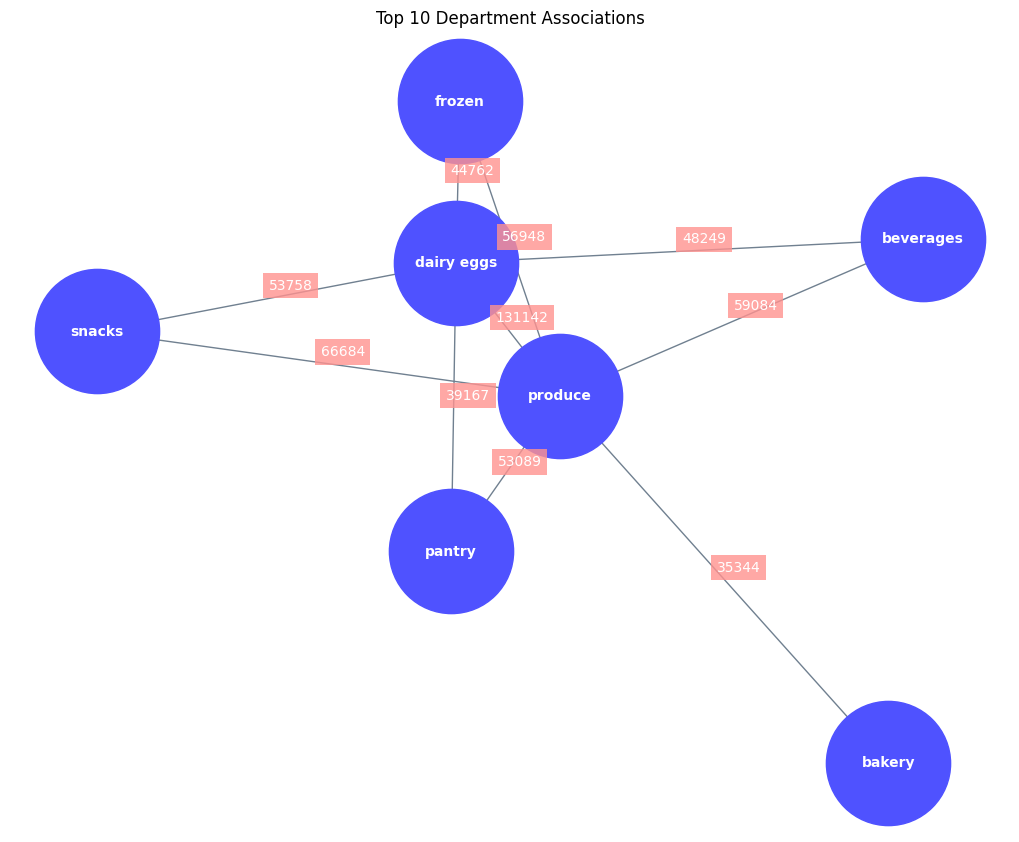

In [6]:
# Garder les 10 paires les plus fréquentes
top_10_pairs = dict(pair_counts.most_common(10))

# Créer le graphe
G = nx.Graph()

for pair, count in top_10_pairs.items():
    G.add_edge(pair[0], pair[1], weight=count)

# Utiliser un layout avec une distance idéale ajustée
pos = nx.spring_layout(G, weight='weight', k=0.7, seed=42)  # Ajuster 'k' pour une meilleure séparation

# Dessiner le graphe
plt.figure(figsize=(10, 8))
nx.draw(
    G, pos,
    with_labels=True,
    node_size=8000,
    node_color='#4f52ff',
    font_color='white',
    # alpha=0.8,
    font_size=10,
    font_weight='bold',
    edge_color='slategray',
    width=1
)

# Ajouter les poids des arêtes en ajustant leur position
labels = nx.get_edge_attributes(G, 'weight')
for (n1, n2), label in labels.items():
    # Position au milieu de l'arête
    x = (pos[n1][0] + pos[n2][0]) / 2
    y = (pos[n1][1] + pos[n2][1]) / 2
    # Légère déviation verticale pour éviter le chevauchement
    y += 0.02
    x += 0.02
    plt.text(x, y, str(label), fontsize=10, color='white', ha='center', bbox=dict(facecolor='#ff928f', alpha=0.8, edgecolor='none'))

# Ajouter un titre
plt.title('Top 10 Department Associations')
plt.show()


11. Which aisles are frequently associated with each other in customer orders?

In [7]:
orders_products = orders.merge(order_products, on='order_id', how='left').merge(products, on='product_id', how='left').merge(aisles, on='aisle_id', how='left')
orders_products_group = orders_products.groupby('order_id')['aisle'].apply(list).reset_index()

# Chercher les association
aisles_pairing = []
for group in orders_products_group['aisle']:
    # Trier et créer des paires uniques (éviter doublons)
    aisles_pairing.extend(combinations(sorted(set(group)), 2))

# Compter les paires de produits
pair_counts = Counter(aisles_pairing)

# Afficher les paires les plus fréquentes
print("Association d'allées les plus fréquentées :")
for pair, count in pair_counts.most_common(10):
    print(f"{pair}: {count} fois")

    # Garder les 10 paires les plus fréquentes de pair_counts
top_10_pairs = dict(pair_counts.most_common(10))


# Export en csv
df_most_common_pairs = pd.DataFrame(top_10_pairs, columns=['Pair', 'Count'])
df_most_common_pairs['Pair'] = df_most_common_pairs['Pair'].apply(lambda x: f"{x[0]} & {x[1]}")
df_most_common_pairs.to_csv('association_aisles.csv', index=False, encoding='utf-8')

Association d'allées les plus fréquentées :
('fresh fruits', 'fresh vegetables'): 54651 fois
('fresh fruits', 'packaged vegetables fruits'): 34661 fois
('fresh vegetables', 'packaged vegetables fruits'): 32536 fois
('fresh fruits', 'yogurt'): 24697 fois
('fresh vegetables', 'yogurt'): 19030 fois
('fresh fruits', 'packaged cheese'): 17523 fois
('fresh fruits', 'milk'): 16290 fois
('fresh vegetables', 'packaged cheese'): 16089 fois
('packaged vegetables fruits', 'yogurt'): 13116 fois
('fresh vegetables', 'milk'): 12730 fois


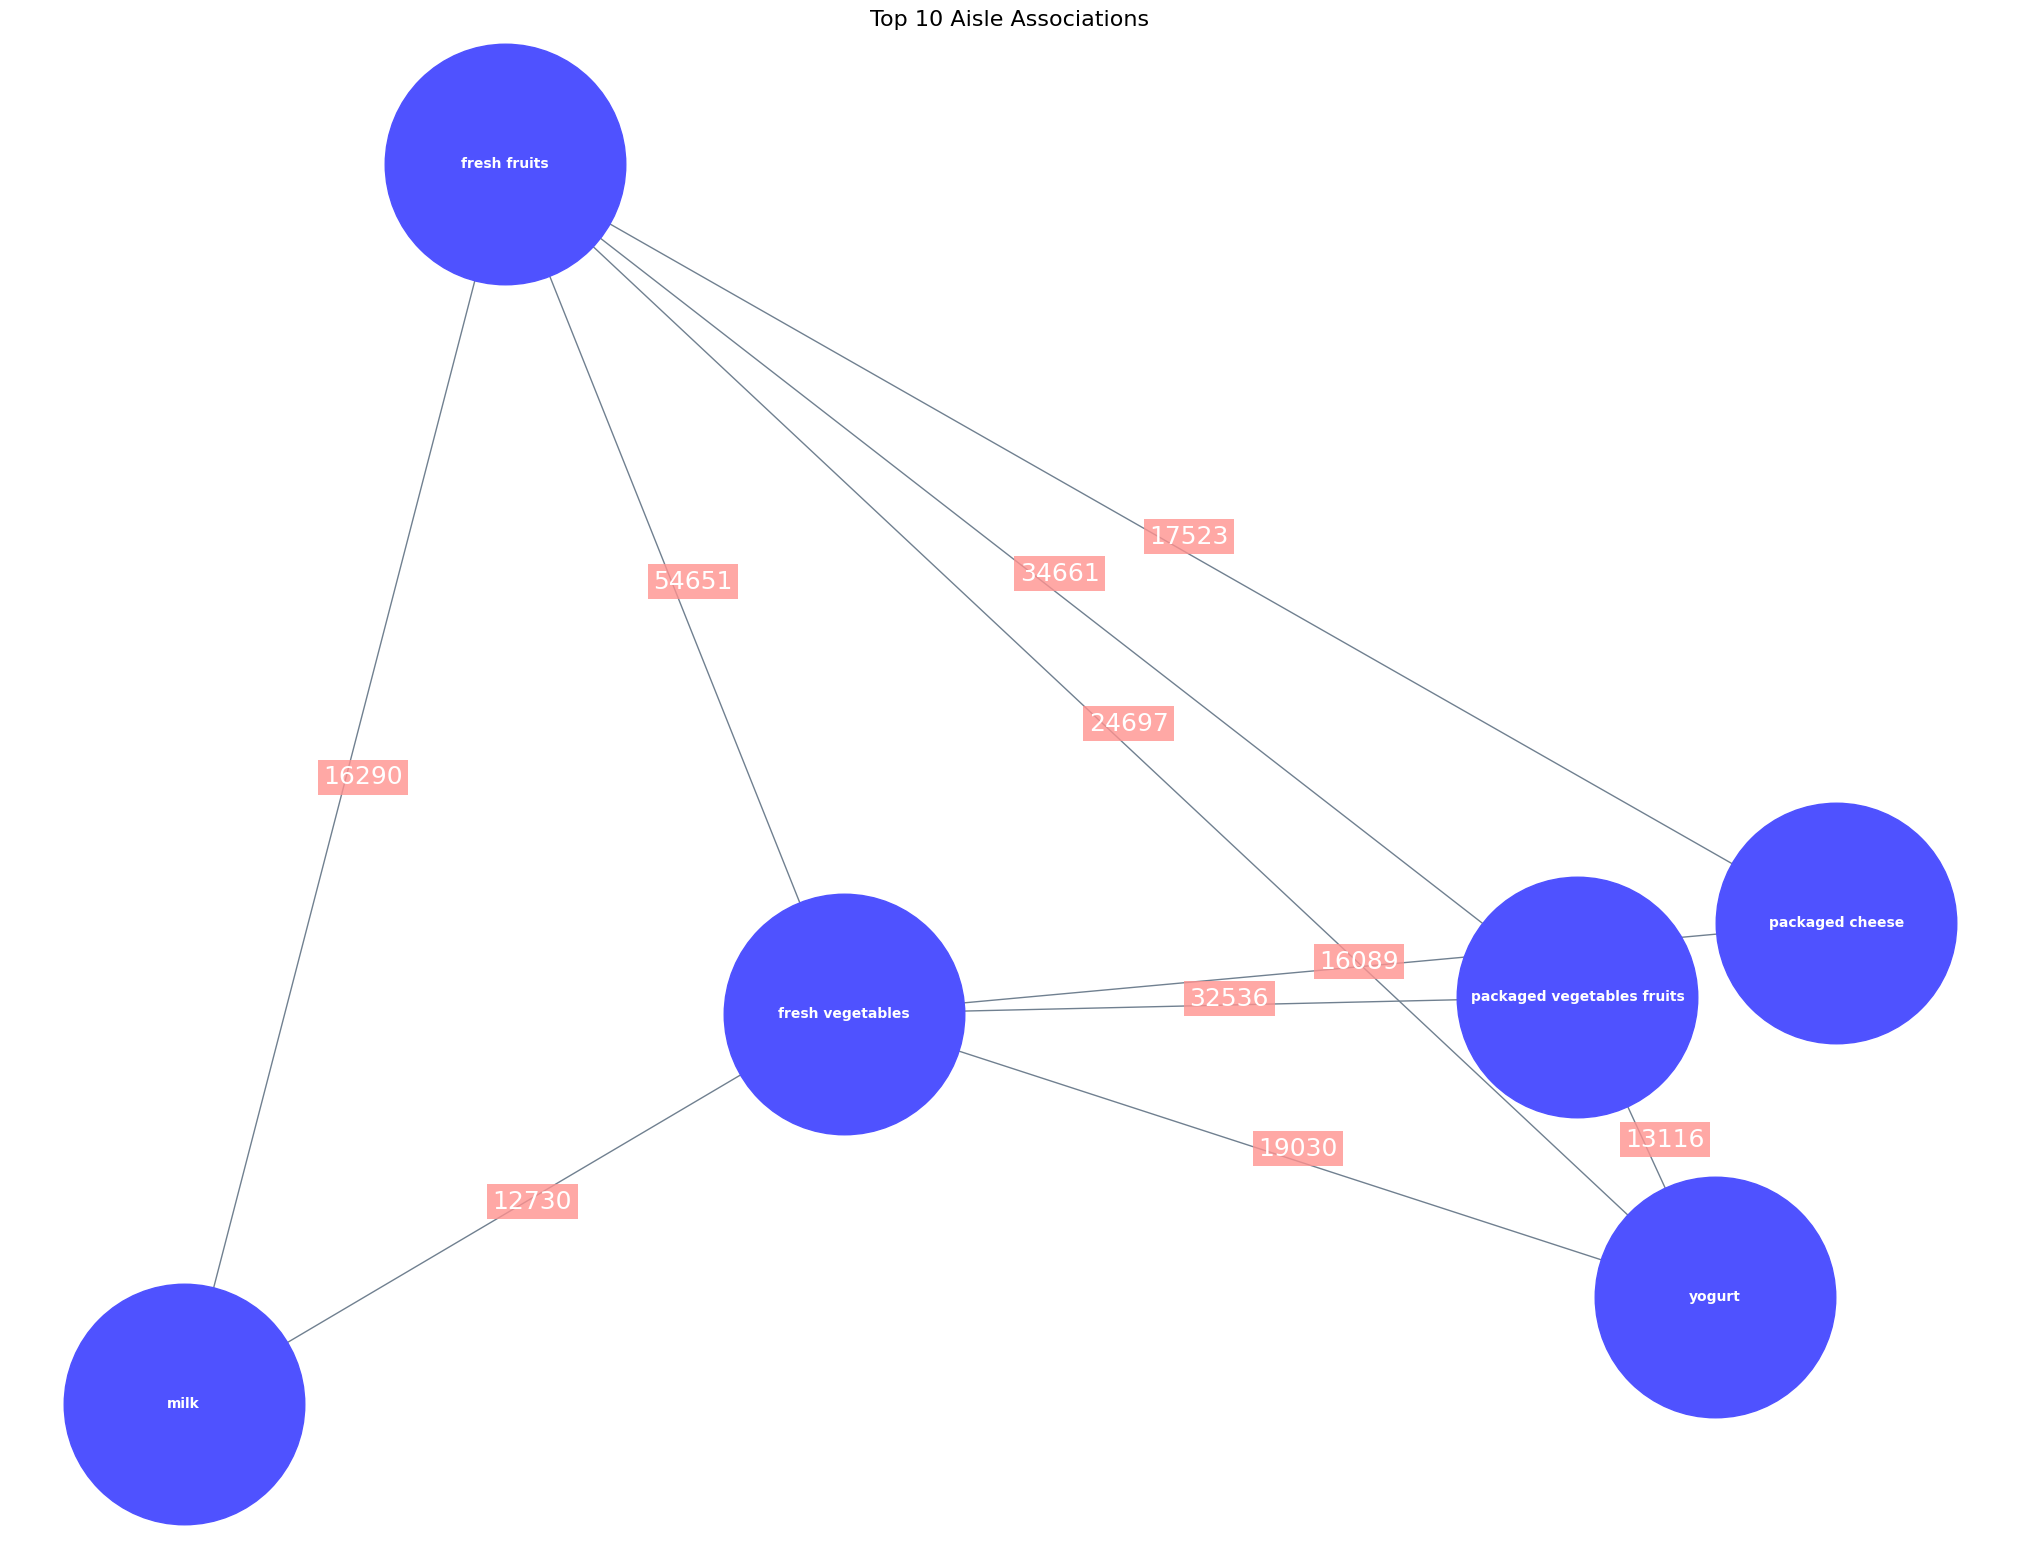

In [11]:
import matplotlib.pyplot as plt
import networkx as nx

# Garder les 10 paires les plus fréquentes
top_10_pairs = dict(pair_counts.most_common(10))

# Créer le graphe
G = nx.Graph()

for pair, count in top_10_pairs.items():
    G.add_edge(pair[0], pair[1], weight=count)

# Utiliser un layout basé sur les poids
pos = nx.spring_layout(G, weight='weight', k=0.1, seed=42)  # Ajuster 'k' pour la distance idéale

# Dessiner le graphe
plt.figure(figsize=(20, 15))
nx.draw(
    G, pos,
    with_labels=True,
    node_size=30000,
    node_color='#4f52ff',
    font_color='white',
    font_size=10,
    font_weight='bold',
    edge_color='slategray',
    width=1
)

# Ajouter les poids des arêtes
labels = nx.get_edge_attributes(G, 'weight')
for (n1, n2), label in labels.items():
    # Position au milieu de l'arête
    x = (pos[n1][0] + pos[n2][0]) / 2
    y = (pos[n1][1] + pos[n2][1]) / 2
    # Légère déviation pour éviter le chevauchement
    x += 0.02
    # y += 0.02
    plt.text(x, y, str(label), fontsize=18, color='white', ha='center', bbox=dict(facecolor='#ff928f', alpha=0.8, edgecolor='none'))

# Ajouter un titre
plt.title('Top 10 Aisle Associations', fontsize=16)
plt.show()

# 3. Raising awareness of sustainable shopping practices by segmenting customers

**Problem Statement:**

How can user segmentation based on purchasing behavior help raise awareness of sustainable shopping practices and encourage eco-friendly decisions?

By identifying these two segments, businesses can tailor initiatives to promote eco-friendly behaviors, such as reducing packaging waste, to customers who favor unpackaged products. At the same time, the packaged-product group can be targeted with practical solutions that encourage sustainability without compromising convenience. The challenge is to effectively engage both groups in adopting more sustainable shopping habits.

12. How do the proportions of packaged versus fresh product preferences vary between different user groups, and what does this reveal about consumer behavior?

In [13]:
# Merge datasets to include user_id and aisle information
order_products_aisles = order_products.merge(products[['product_id', 'aisle_id']], on='product_id', how='left')
order_products_aisles = order_products_aisles.merge(aisles[['aisle_id', 'aisle']], on='aisle_id', how='left')
order_products_aisles = order_products_aisles.merge(orders[['order_id', 'user_id']], on='order_id', how='left')

# Filter packaged and fresh fruits/vegetables
packaged = order_products_aisles[order_products_aisles['aisle'].str.contains('packaged vegetables fruits|packaged produce', na=False)]
fresh = order_products_aisles[order_products_aisles['aisle'].str.contains('fresh fruits|fresh vegetables', na=False)]

# Count purchases by user
packaged_count = packaged.groupby('user_id').size()
fresh_count = fresh.groupby('user_id').size()

# Create user preferences DataFrame
user_preferences = pd.DataFrame({
    'packaged': packaged_count,
    'fresh': fresh_count
}).fillna(0)

# Add total purchases and proportions
user_preferences['total'] = user_preferences['packaged'] + user_preferences['fresh']
user_preferences['prop_packaged'] = user_preferences['packaged'] / user_preferences['total']
user_preferences['prop_fresh'] = user_preferences['fresh'] / user_preferences['total']


# Perform clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

X = user_preferences[['prop_packaged', 'prop_fresh']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=2, random_state=42)
user_preferences['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize proportions per cluster
import plotly.graph_objects as go

cluster_proportions = user_preferences.groupby('cluster')[['prop_packaged', 'prop_fresh']].mean().reset_index()

for cluster in cluster_proportions['cluster']:
    cluster_data = cluster_proportions[cluster_proportions['cluster'] == cluster]
    fig = go.Figure(data=[go.Pie(
        labels=['Packaged', 'Fresh'],
        values=[cluster_data['prop_packaged'].values[0], cluster_data['prop_fresh'].values[0]],
        hole=0.3,
        marker=dict(colors=['#ea8383', '#469f78'])
    )])
    fig.update_layout(title=f'Packaged vs. Fresh Proportions - Cluster {cluster}')
    fig.show()

# Count users per cluster
cluster_counts = user_preferences['cluster'].value_counts().reset_index()
cluster_counts.columns = ['Cluster', 'User Count']

# Visualize user count per cluster
import plotly.express as px

fig = px.bar(cluster_counts,
             x='Cluster',
             y='User Count',
             title='User Distribution by Cluster',
             color='Cluster',
             color_discrete_map={0: '#469f78', 1: '#ea8383'})
fig.update_traces(marker=dict(color=['#469f78', '#ea8383']))


# Formatter et exporter en csv
cluster_proportions['prop_packaged'] = (cluster_proportions['prop_packaged'] * 100).round(2)
cluster_proportions['prop_fresh'] = (cluster_proportions['prop_fresh'] * 100).round(2)


for cluster in cluster_proportions['cluster']:

    cluster_data = cluster_proportions[cluster_proportions['cluster'] == cluster]
    result_table = pd.DataFrame({
        'products': ['packaged', 'fresh'],
        'pourcent': [cluster_data['prop_packaged'].values[0], cluster_data['prop_fresh'].values[0]]
    })

    file_name = f'cluster_proportions_cluster_{cluster}.csv'  # Nom du fichier
    result_table.to_csv(file_name, index=False, encoding='utf-8')

cluster_counts.to_csv('cluster_counts.csv', index=False, encoding='utf-8')



fig.show()
